In [ ]:
#Create NetflixEnv python=3.12 environment and install the following libraries from requirements.txt file.
# .\netflixEnv\Scripts\activate

In [4]:
import pandas as pd
import numpy as np
import dateutil.parser as dparser
import matplotlib.pyplot as plt
import seaborn as sns
# import plotly.graph_objects as go

from nltk.corpus import stopwords
from rake_nltk import Rake
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud

crest_palette = sns.color_palette("crest", 2)

In [5]:
df = pd.read_csv(r'netflix_titles.csv')
df.head(2)

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,NaN,United States,"September 25, 2021",2020,PG-13,90 min,Documentaries,"As her father nears the end of his life, filmm..."
1,s2,TV Show,Blood & Water,NaN,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t..."


### Overview of Netflix Dataset

In [6]:
#Size of Data
df.shape

(8807, 12)

In [7]:
# There are total 12 columns with 8807 records in dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8807 entries, 0 to 8806
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   show_id       8807 non-null   object
 1   type          8807 non-null   object
 2   title         8807 non-null   object
 3   director      6173 non-null   object
 4   cast          7982 non-null   object
 5   country       7976 non-null   object
 6   date_added    8797 non-null   object
 7   release_year  8807 non-null   int64 
 8   rating        8803 non-null   object
 9   duration      8804 non-null   object
 10  listed_in     8807 non-null   object
 11  description   8807 non-null   object
dtypes: int64(1), object(11)
memory usage: 825.8+ KB


In [8]:
# Descriptive Statistics
df.describe()

,release_year
count,8807.000000
mean,2014.180198
std,8.819312
min,1925.000000
25%,2013.000000
50%,2017.000000
75%,2019.000000
max,2021.000000


In [9]:
df.columns

Index(['show_id', 'type', 'title', 'director', 'cast', 'country', 'date_added',
       'release_year', 'rating', 'duration', 'listed_in', 'description'],
      dtype='object')

### Data Cleaning

In [10]:
# Optimizing column headers
df.columns = df.columns.str.replace('_',' ').str.title()
df.columns

Index(['Show Id', 'Type', 'Title', 'Director', 'Cast', 'Country', 'Date Added',
       'Release Year', 'Rating', 'Duration', 'Listed In', 'Description'],
      dtype='object')

In [11]:
# Handling duplicated records
df.duplicated(subset=['Director','Cast','Country','Date Added','Rating','Duration'])
df.drop_duplicates()
df.shape

(8807, 12)

In [12]:
# Handling Dates 
df['Date'] = df['Date Added'].apply(lambda date: dparser.parse(str(date),fuzzy=True).date()if pd.notnull(date) else date)
df['Date'] = pd.to_datetime(df['Date'],format="%d-%m-%Y", errors='coerce')  
df['Month'] = df['Date'].dt.month
df['Year'] = df['Date'].dt.year 
df['Year'] = df['Year'].fillna('2020').astype(int)

In [13]:
# Handling null records

#From above info() table, we can say that the following columns do not have 8807 records. 
df['Director'] = df['Director'].fillna('Anonymous')
df['Cast'] = df['Cast'].fillna('Anonymous')
df['Country'] = df['Country'].fillna('Not Applicable')
df['Date Added'] = df['Date Added'].fillna('Not Available')
df['Rating'] = df['Rating'].fillna('Unavailable')

In [14]:
# Run this cell only once orelse it will shift the values back again to Rating as 74 mins
# 'Duration' has been entered in 'Rating' column, which is a case of data discrepancy.
df.loc[df['Show Id']=='s5542', ['Rating','Duration']] = df.loc[df['Show Id']=='s5542', ['Duration','Rating']].values
df.loc[df['Show Id']=='s5795', ['Rating','Duration']] = df.loc[df['Show Id']=='s5795', ['Duration','Rating']].values
df.loc[df['Show Id']=='s5814', ['Rating','Duration']] = df.loc[df['Show Id']=='s5814', ['Duration','Rating']].values

df['Rating'] = df['Rating'].fillna('Unavailable')

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8807 entries, 0 to 8806
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Show Id       8807 non-null   object        
 1   Type          8807 non-null   object        
 2   Title         8807 non-null   object        
 3   Director      8807 non-null   object        
 4   Cast          8807 non-null   object        
 5   Country       8807 non-null   object        
 6   Date Added    8807 non-null   object        
 7   Release Year  8807 non-null   int64         
 8   Rating        8807 non-null   object        
 9   Duration      8807 non-null   object        
 10  Listed In     8807 non-null   object        
 11  Description   8807 non-null   object        
 12  Date          8797 non-null   datetime64[ns]
 13  Month         8797 non-null   float64       
 14  Year          8807 non-null   int32         
dtypes: datetime64[ns](1), float64(1), int3

### Exploratory Analysis

#### Distribution of Content

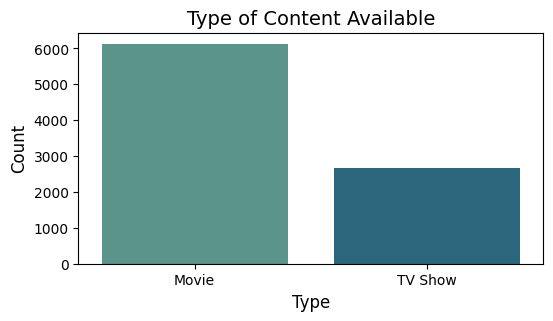

In [13]:
# Number of movies is approximately twice the number of tv shows
plt.figure(figsize=(6, 3))
sns.countplot(x ='Type', data = df, palette='crest', hue='Type')

plt.xlabel('Type', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.title('Type of Content Available', fontsize=14)
plt.show()

#### Year that has highest number of releases

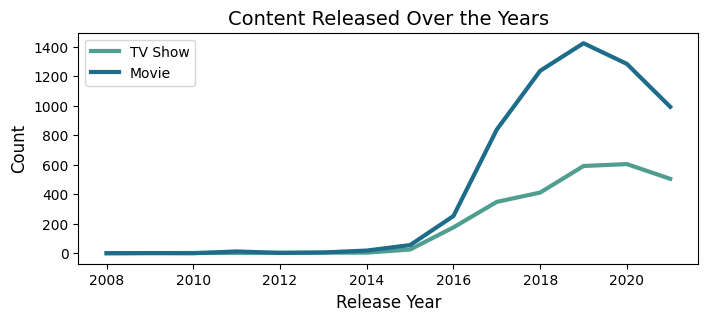

In [16]:
# For movies - after 2018 and for Tv shows its after 2019-2020
highest_release = df.groupby('Year')['Type'].value_counts().unstack(level=-1)

plt.figure(figsize=(8, 3))

sns.lineplot(x='Year', y='TV Show', data=highest_release, linewidth=3, label='TV Show', color=crest_palette[0])
sns.lineplot(x='Year', y='Movie', data=highest_release, linewidth=3, label='Movie', color=crest_palette[1])

plt.xlabel('Release Year', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.title('Content Released Over the Years', fontsize=14)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.legend(fontsize=10)
plt.show()


#### Year with least releases

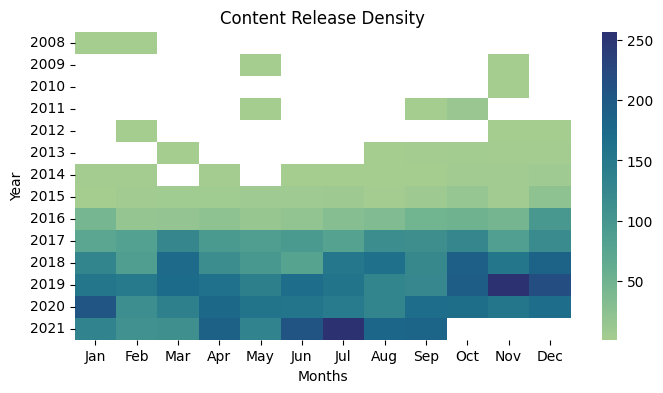

In [17]:
# In the year 2020, February, March and May are months to add new content.
least_releases = df.groupby('Year')['Month'].value_counts().unstack()
least_releases.columns = pd.to_datetime(least_releases.columns, format='%m').strftime('%b')

figure, axes = plt.subplots(1,1,figsize = (8,4))
axes = sns.heatmap(least_releases,cmap="crest")
plt.xlabel('Months')
plt.ylabel('Year')
plt.title('Content Release Density')
plt.show()

#### Country with highest Releases

C:\Users\rohan\AppData\Local\Temp\ipykernel_16576\3347943323.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y='Country', data=df, palette='crest', order=df[df['Country'] != 'Not Applicable']['Country'].value_counts().index[:10])


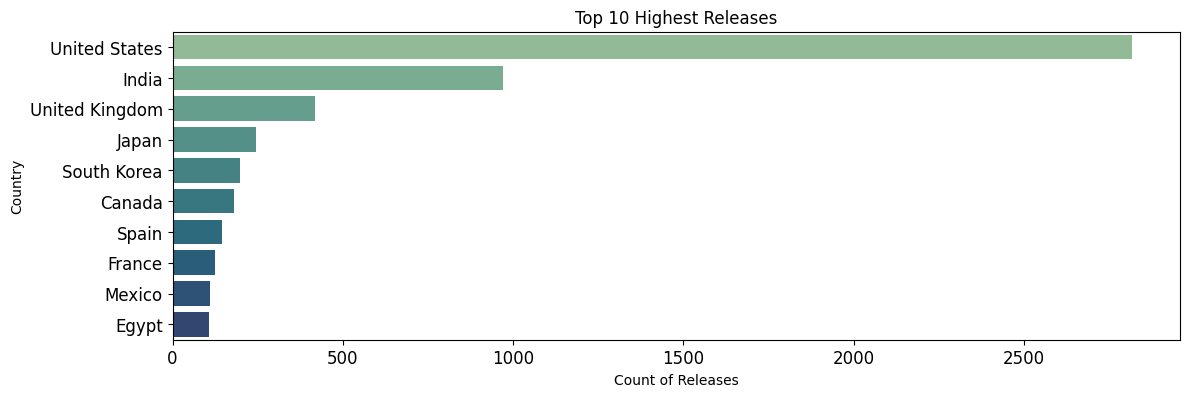

In [18]:
# United States has highest releases
figure, axes = plt.subplots(figsize=(13,4))
sns.countplot(y='Country', data=df, palette='crest', order=df[df['Country'] != 'Not Applicable']['Country'].value_counts().index[:10])

plt.xlabel('Count of Releases')
plt.ylabel('Country')
plt.title('Top 10 Highest Releases')
plt.tick_params(labelsize=12)
plt.show()

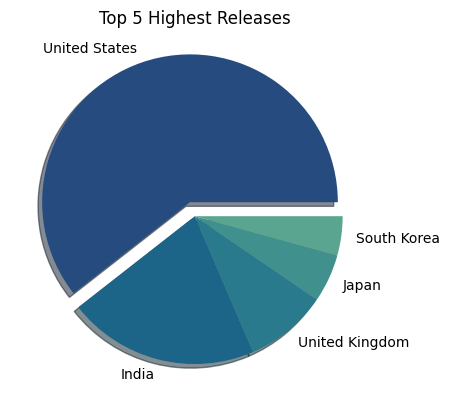

In [19]:
country_count = df[df['Country'] != 'Not Applicable']['Country'].value_counts()
z = np.zeros(748)
z[0] = 0.1

labels = []
for i in country_count[:5].index:
    labels.append(i)

figure, axes = plt.subplots()
explode = (0.1, 0, 0, 0)
axes.pie(country_count[:5],explode=z[:5],labels = labels, radius = 1, shadow = True,
       textprops = {'fontsize':10}, colors=sns.color_palette('crest_r'))

plt.title('Top 5 Highest Releases')
plt.show()

#### Genre Analysis

C:\Users\rohan\AppData\Local\Temp\ipykernel_22176\2595303508.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Genre',y='Number of Movies',data=genre_df.head(7),palette='crest_r')


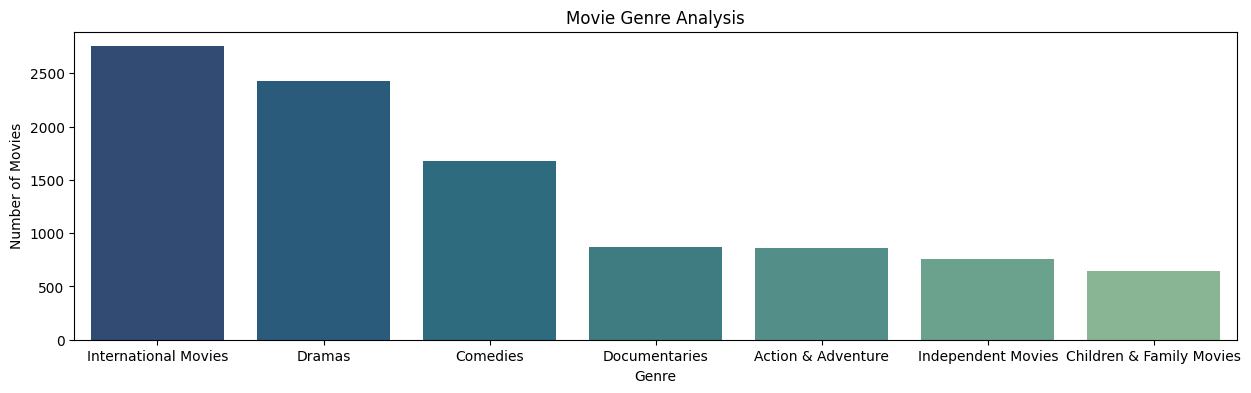

In [14]:
# International movies and Internation Tv-shows top the chart
movies_df = df[df['Type'] == 'Movie']

movies_df_genre = movies_df['Listed In'].str.split(str.strip())
genres_counts = movies_df_genre.value_counts()
genre_df = pd.DataFrame({'Genre': genres_counts.index, 'Number of Movies': genres_counts.values})

figure, axes = plt.subplots(figsize=(15,4))
sns.barplot(x='Genre',y='Number of Movies',data=genre_df.head(7),palette='crest_r')
plt.tick_params(labelsize=10)
plt.title('Movie Genre Analysis')
plt.show()


In [16]:
genres_counts

Listed In
International Movies        2752
Dramas                      2427
Comedies                    1674
Documentaries                869
Action & Adventure           859
Independent Movies           756
Children & Family Movies     641
Romantic Movies              616
Thrillers                    577
Music & Musicals             375
Horror Movies                357
Stand-Up Comedy              343
Sci-Fi & Fantasy             243
Sports Movies                219
Classic Movies               116
LGBTQ Movies                 102
Anime Features                71
Cult Movies                   71
Faith & Spirituality          65
Movies                        57
Name: count, dtype: int64

C:\Users\Manali\AppData\Local\Temp\ipykernel_25340\998323350.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Genre',y='Number of Movies',data=genre_df.head(7),palette='crest_r')


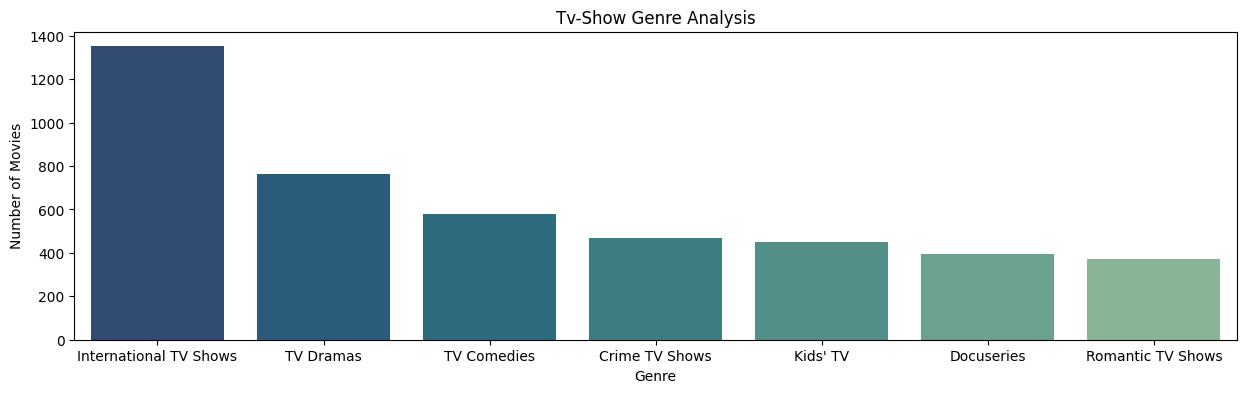

In [20]:
show_df = df[df['Type'] == 'TV Show']

show_df_genre = show_df['Listed In'].str.split(',').explode().str.strip()
genres_counts = show_df_genre.value_counts()
genre_df = pd.DataFrame({'Genre': genres_counts.index, 'Number of TvShows': genres_counts.values})

figure, axes = plt.subplots(figsize=(15,4))
sns.barplot(x='Genre',y='Number of TvShows',data=genre_df.head(7),palette='crest_r')
plt.tick_params(labelsize=10)
plt.title('Tv-Show Genre Analysis')
plt.show()

#### Genre Anlaysis - WordCloud

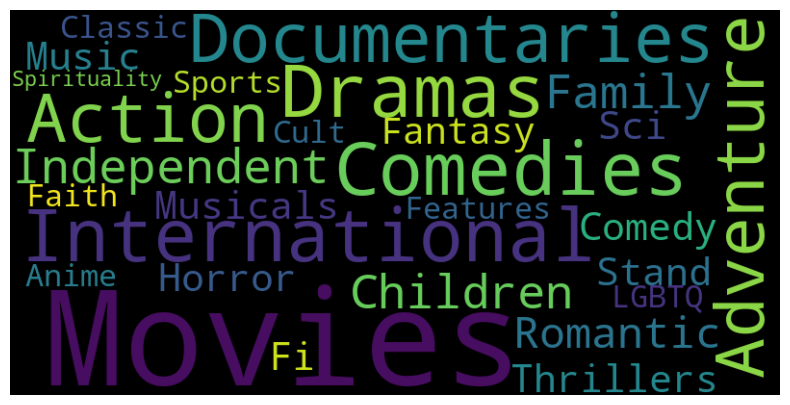

In [21]:
text = ' '.join(genres_counts.index)
wordcloud = WordCloud(width=800, height=400,background_color='black').generate(str(text))

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud,interpolation='bilinear')
plt.axis('off')
plt.show()

#### Duration Analysis

In [22]:
# So, a good amount of movies on Netflix are among the duration of 75-120 mins. 
movies_df['Duration'] = movies_df['Duration'].str.replace('min', ' ').str.replace('Season', ' ').str.strip()
movies_df['Duration'] = movies_df['Duration'].astype(int)

C:\Users\rohan\AppData\Local\Temp\ipykernel_16576\632288059.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movies_df['Duration'] = movies_df['Duration'].str.replace('min', ' ').str.replace('Season', ' ').str.strip()
C:\Users\rohan\AppData\Local\Temp\ipykernel_16576\632288059.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movies_df['Duration'] = movies_df['Duration'].astype(int)


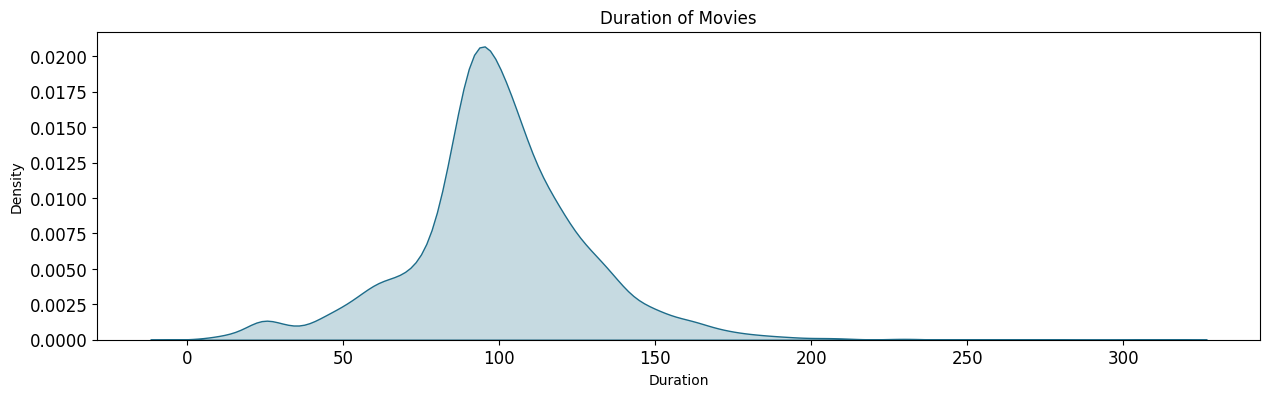

In [23]:
duration_min = movies_df[movies_df['Duration'] > 1]
plt.figure(figsize=(15,4))
sns.kdeplot(data=duration_min['Duration'], fill=True, color=crest_palette[1])
plt.title('Duration of Movies')
plt.tick_params(labelsize=12)
plt.show()

In [24]:
show_df['Duration'] = show_df['Duration'].str.replace('Seasons', ' ').str.replace('Season', ' ').str.strip()
show_df['Duration'] = show_df['Duration'].astype(int)

C:\Users\Manali\AppData\Local\Temp\ipykernel_25340\427384354.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  show_df['Duration'] = show_df['Duration'].str.replace('Seasons', ' ').str.replace('Season', ' ').str.strip()
C:\Users\Manali\AppData\Local\Temp\ipykernel_25340\427384354.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  show_df['Duration'] = show_df['Duration'].astype(int)


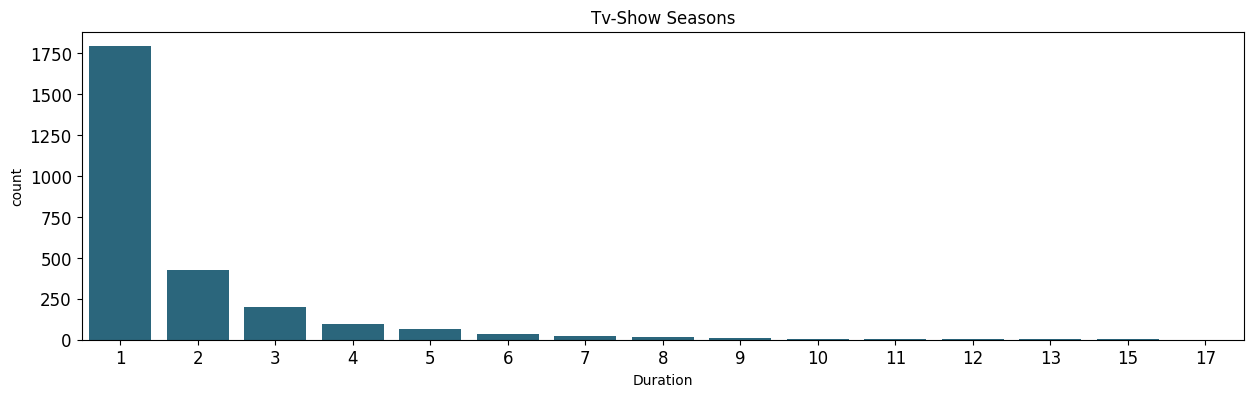

In [25]:
plt.figure(figsize=(15,4))
sns.countplot(x= show_df['Duration'], data=show_df, color = crest_palette[1])
plt.title('Tv-Show Seasons')
plt.tick_params(labelsize=12)
plt.show()

#### Rating Analysis

In [26]:
# h_lim is set for the text of individual bars
def rating_barplot(data,title,height,h_lim = None):
    figure , axes = plt.subplots(1,1, figsize = (14,4))
    if h_lim:
        axes.set_ylim(0,h_lim)
    axes.bar(data.index , data , color = '#d0d0d0' , width = 0.6 , edgecolor = 'black')
    
    color = ['green' , 'blue' , 'orange' , 'red']
    span_range = [[0,2] , [3,6] , [7,8] , [9,11]]
    
    #Setting individual patterns
    for idx , sub_title in enumerate(['Little Kids' , 'Older Kids' , 'Teens' , 'Mature']):
        axes.annotate(sub_title , 
                   xy = (sum(span_range[idx])/2 ,height),
                   xytext = (0,0) , textcoords = 'offset points',
                   va = 'center' , ha = 'center',
                   color = 'w' , fontsize = 12 , fontweight = 'bold',
                   bbox = dict(boxstyle = 'round4' , pad = 0.4 , color = color[idx] , alpha = 0.6))
        axes.axvspan(span_range[idx][0]-0.4 , span_range[idx][1]+0.4 , color = color[idx], alpha = 0.1)
    axes.set_title(f'Distribution of {title} Rating',fontsize = 12 , fontweight = 'bold' , position = (0.5, 1.0 + 0.03))
    plt.xlabel('Ratings')
    plt.ylabel('Count')
    plt.show()

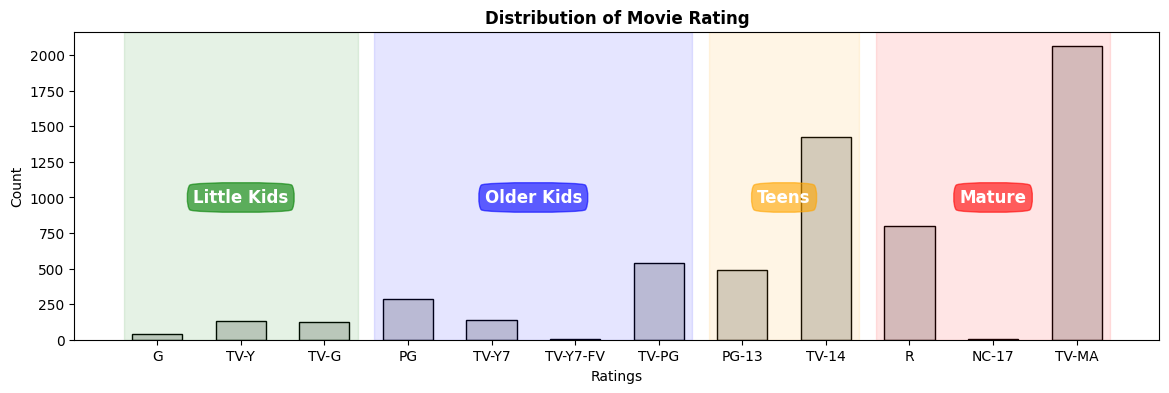

In [27]:
rating_order = ['G' , 'TV-Y' , 'TV-G' , 'PG' , 'TV-Y7' , 'TV-Y7-FV' , 'TV-PG' , 'PG-13' , 'TV-14' , 'R' , 'NC-17' ,'TV-MA']
movie_rating = movies_df['Rating'].value_counts()[rating_order]
rating_barplot(movie_rating ,'Movie',5)

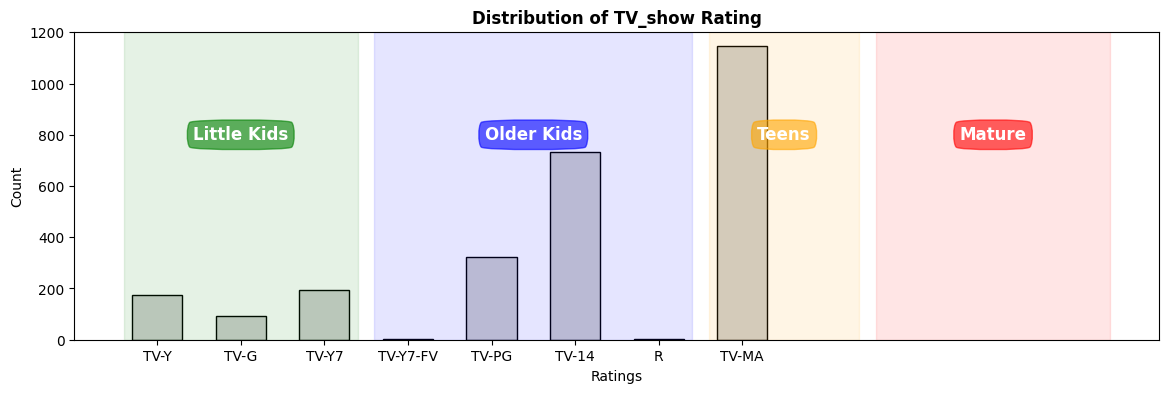

In [28]:
rating_order = [ 'TV-Y' , 'TV-G' , 'TV-Y7' , 'TV-Y7-FV' , 'TV-PG'  , 'TV-14' , 'R'  ,'TV-MA']
tv_rating = show_df['Rating'].value_counts()[rating_order].fillna(0)
rating_barplot(tv_rating ,'TV_show', 800)

#### Most popular Movie or Tv-show

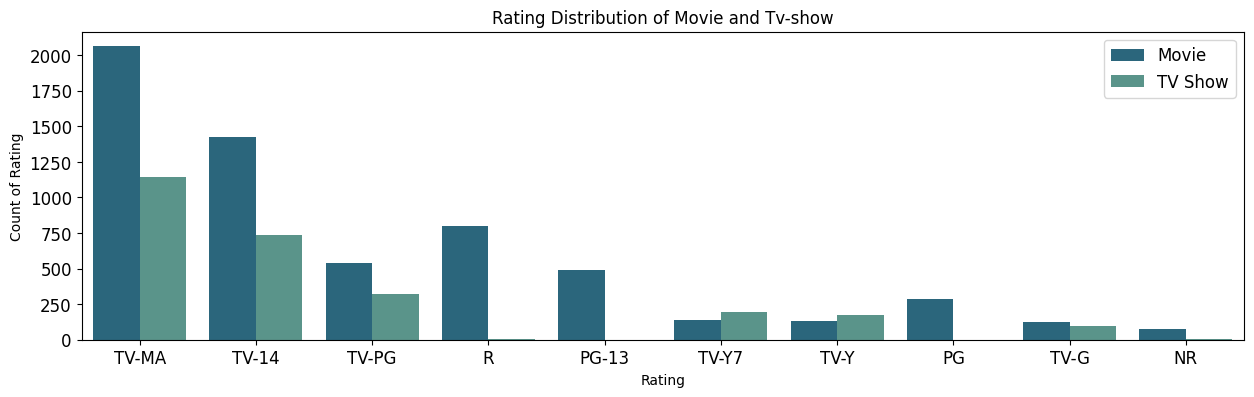

In [29]:
# TV-MA or Adults is the most popular rating for both movies and tv-shows
figure, axes = plt.subplots(1,1,figsize=(15,4))
sns.countplot(x='Rating', data=df, palette='crest_r', hue='Type', order=df['Rating'].value_counts().index[0:10])
plt.tick_params(labelsize=12)
plt.legend(fontsize=12)
plt.ylabel('Count of Rating')
plt.title('Rating Distribution of Movie and Tv-show')
plt.show()

#### TV-shows with most seasons

In [30]:
# Grey's Anatomy has the highest seasons
show_df[['Duration','Title']].sort_values(by='Duration', ascending = False).head(5)

,Duration,Title
548,17,Grey's Anatomy
2423,15,Supernatural
4798,15,NCIS
1354,13,Heartland
4220,13,COMEDIANS of the world


#### Directors with highest number of Movies and Tv-shows

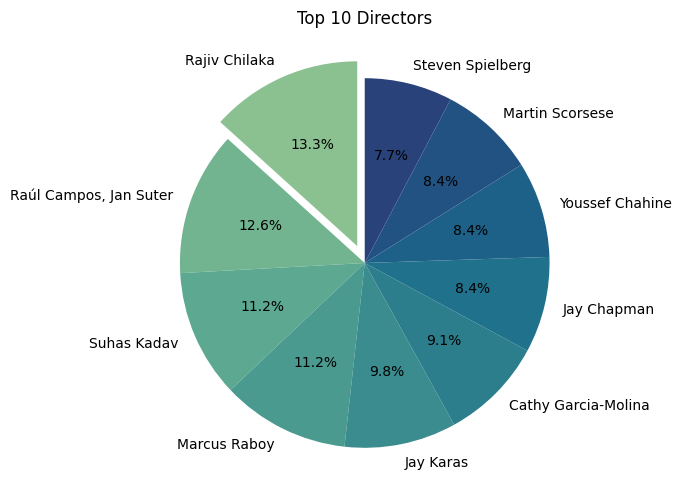

In [31]:
director_df = df['Director'].value_counts().iloc[1:11].to_dict()

director = pd.DataFrame(list(director_df.items()), columns=['Director', 'Count'])
explode = (0.1, 0, 0,0,0,0,0,0,0,0)

plt.figure(figsize=(6,6))
plt.pie(director['Count'], labels=director['Director'], autopct='%1.1f%%', 
        startangle=90, colors=sns.color_palette('crest', n_colors=10), explode=explode)
plt.title('Top 10 Directors')
plt.show()

#### Popular Directors on Netflix by Country

C:\Users\Manali\AppData\Local\Temp\ipykernel_25340\2842848523.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y='Director', data=indian_per, palette='crest_r',


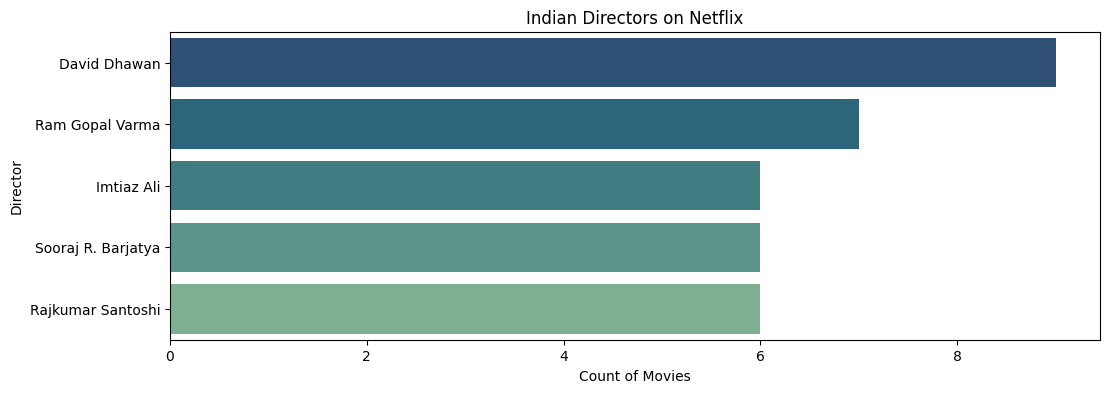

In [32]:
# David Dhawan has 8+ movies on Netflix
indian_per = df[df['Country'] == 'India']
pd.DataFrame(dict(indian_per[['Title', 'Director']].items()))

figure = plt.figure(figsize = (12,4))
sns.countplot(y='Director', data=indian_per, palette='crest_r', 
              order=indian_per[indian_per['Director'] != 'Anonymous']['Director'].value_counts().index[0:5])
plt.xlabel('Count of Movies')
plt.title('Indian Directors on Netflix', fontsize=12)
plt.show()

####  Movies and TV shows produced by each country every year

In [33]:
movies_produced = df[df['Country']!='Not Applicable'].groupby(
                    ['Type','Country'])['Country'].value_counts().reset_index().sort_values(by=['count'], ascending=False)
movies_produced.head(10)

,Type,Country,count
525,Movie,United States,2058
218,Movie,India,893
811,TV Show,United States,760
791,TV Show,United Kingdom,213
440,Movie,United Kingdom,206
734,TV Show,Japan,169
771,TV Show,South Korea,158
50,Movie,Canada,122
384,Movie,Spain,97
128,Movie,Egypt,92


#### Popular Actors Movie and Tv-show

In [34]:
cast_df = df[df['Cast']!='Anonymous']['Cast'].str.split(', ').explode().value_counts().reset_index()
cast_df.head(5)

,Cast,count
0,Anupam Kher,43
1,Shah Rukh Khan,35
2,Julie Tejwani,33
3,Naseeruddin Shah,32
4,Takahiro Sakurai,32


In [35]:
df_cast=show_df.groupby(['Cast']).agg({"Title":"nunique"}).reset_index().sort_values(by=['Title'], 
                                                                                      ascending=False)
df_cast=df_cast[df_cast['Cast']!='Anonymous']
df_cast.head(5)

,Cast,Title
506,David Attenborough,14
1494,"Michela Luci, Jamie Watson, Anna Claire Bartla...",4
502,Dave Chappelle,3
1914,"Shahd El Yaseen, Shaila Sabt, Hala, Hanadi Al-...",2
1406,Marie Kondo,2


### Recommendation System

In [ ]:
# Recommendation Systems are the systems that predict and filter the future preferences of user based based on their past experience. They are widely to recommend :
#     - similar products (Amazon, Flipkart)
#     - relevant media, e.g. photos, videos and stories (Instagram)
#     - relevant series and movies (Netflix, Amazon Prime Video, Hotstar)
#     - relevant songs and podcasts (Spotify)
#     - relevant videos (YouTube)
#     - similar users, posts (LinkedIn, Twitter, Instagram)
#     - relevant dishes and restaurants (Uber Eats, Zomato, Swiggy)

# There are mainly 2 types of Recommendation System
#     - Content Based RS
#     - Collaborative Filtering

#  Rake - Rapid Automatic Keyword Extraction

#### Cleaning and getting Bags of words

In [24]:
data = df[['Title','Director','Cast','Listed In','Description']]
data = data.dropna()
data = data.replace('', pd.NA).dropna()

# Discarding commas between actors full names and getting only the first three names
# Putting the genres in a list of words
# Splitting director's full name into first and last name
# Merging together first and last name for each actor and director so it's considered as one word and there is no mix up between people sharing a first name
data['Cast'] = data['Cast'].apply(lambda x: x.split(',')[:3])
data['Listed In'] = data['Listed In'].str.lower().str.split(',')
data['Director'] = data['Director'].str.lower().str.split(' ')
data['Cast'] = data['Cast'].apply(lambda names: [name.lower().replace(' ','') for name in names])
data['Director'] = data['Director'].apply(lambda names: ''.join(names))

# Instantiate Rake and Extract keywords from 'Description' column and store in 'Keywords' column
r = Rake()
data['Keywords'] = data['Description'].apply(lambda x: r.extract_keywords_from_text(x) or r.get_word_degrees().keys())

data.set_index('Title', inplace=True)

In [25]:
print(data['Director'])

Title
Dick Johnson Is Dead     kirstenjohnson
Blood & Water                 anonymous
Ganglands                julienleclercq
Jailbirds New Orleans         anonymous
Kota Factory                  anonymous
                              ...      
Zodiac                     davidfincher
Zombie Dumb                   anonymous
Zombieland               rubenfleischer
Zoom                        peterhewitt
Zubaan                       mozezsingh
Name: Director, Length: 8807, dtype: object


In [17]:
print(data['Cast']) 

Title
Dick Johnson Is Dead                                        [anonymous]
Blood & Water                     [amaqamata, khosingema, gailmabalane]
Ganglands                       [samibouajila, tracygotoas, samueljouy]
Jailbirds New Orleans                                       [anonymous]
Kota Factory                      [mayurmore, jitendrakumar, ranjanraj]
                                              ...                      
Zodiac                   [markruffalo, jakegyllenhaal, robertdowneyjr.]
Zombie Dumb                                                 [anonymous]
Zombieland                  [jesseeisenberg, woodyharrelson, emmastone]
Zoom                               [timallen, courteneycox, chevychase]
Zubaan                   [vickykaushal, sarah-janedias, raaghavchanana]
Name: Cast, Length: 8807, dtype: object


In [18]:
print(data['Keywords'])

Title
Dick Johnson Is Dead     (father, nears, end, life, filmmaker, kirsten,...
Blood & Water            (crossing, paths, party, cape, town, teen, set...
Ganglands                (protect, family, powerful, drug, lord, skille...
Jailbirds New Orleans    (feuds, flirtations, toilet, talk, go, among, ...
Kota Factory             (city, coaching, centers, known, train, india,...
                                               ...                        
Zodiac                   (political, cartoonist, crime, reporter, pair,...
Zombie Dumb              (living, alone, spooky, town, young, girl, bef...
Zombieland               (looking, survive, world, taken, zombies, dork...
Zoom                     (dragged, civilian, life, former, superhero, m...
Zubaan                   (scrappy, poor, boy, worms, way, tycoon, dysfu...
Name: Keywords, Length: 8807, dtype: object


In [19]:
# Concatenate values from all columns except 'director' into a single string
# Append 'Director' column to the 'Bag_of_Words' string
# Drop all columns except 'Bag_of_Words'
data['Bag_of_Words'] = data.apply(lambda row: ' '.join(map(str, row.drop('Director'))), axis=1)
data['Bag_of_Words'] += ' ' + data['Director']
data = data[['Bag_of_Words']]

In [20]:
print(data)

                                                            Bag_of_Words
Title                                                                   
Dick Johnson Is Dead   ['anonymous'] ['documentaries'] As her father ...
Blood & Water          ['amaqamata', 'khosingema', 'gailmabalane'] ['...
Ganglands              ['samibouajila', 'tracygotoas', 'samueljouy'] ...
Jailbirds New Orleans  ['anonymous'] ['docuseries', ' reality tv'] Fe...
Kota Factory           ['mayurmore', 'jitendrakumar', 'ranjanraj'] ['...
...                                                                  ...
Zodiac                 ['markruffalo', 'jakegyllenhaal', 'robertdowne...
Zombie Dumb            ['anonymous'] ["kids' tv", ' korean tv shows',...
Zombieland             ['jesseeisenberg', 'woodyharrelson', 'emmaston...
Zoom                   ['timallen', 'courteneycox', 'chevychase'] ['c...
Zubaan                 ['vickykaushal', 'sarah-janedias', 'raaghavcha...

[8807 rows x 1 columns]


#### Fearture Extraction and Modelling

In [21]:
# instantiating and generating the count matrix
count = CountVectorizer()
count_matrix = count.fit_transform(data['Bag_of_Words'])

# creating a Series for the movie titles so they are associated to an ordered numerical list to match the indexes
indices = pd.Series(data.index)

# Generating the cosine similarity matrix
cosine_sim = cosine_similarity(count_matrix, count_matrix)

In [22]:
print(cosine_sim)

[[1.         0.04637389 0.10112998 ... 0.06588078 0.1        0.13499219]
 [0.04637389 1.         0.14590459 ... 0.02444119 0.01159347 0.03414607]
 [0.10112998 0.14590459 1.         ... 0.05922242 0.05618332 0.17650757]
 ...
 [0.06588078 0.02444119 0.05922242 ... 1.         0.07905694 0.05174337]
 [0.1        0.01159347 0.05618332 ... 0.07905694 1.         0.0736321 ]
 [0.13499219 0.03414607 0.17650757 ... 0.05174337 0.0736321  1.        ]]


In [23]:
# Function that takes in movie title as input and returns the top 5 recommended movies
def getRecommendations(data, title, indices, cosine_sim):
    
    recommended_movies = []
    # Getting the index of the movie that matches the title
    idx = indices[indices == title].index[0]

    # Creating a Series with the similarity scores in descending order
    score_series = pd.Series(cosine_sim[idx]).sort_values(ascending = False)

    # Getting the indexes of the 6 most similar movies
    top_indexes = list(score_series.iloc[1:6].index)
    
    # Populating the list with the titles of the best 10 matching movies
    for i in top_indexes:
        recommended_movies.append(list(data.index)[i])
        
    return recommended_movies

#### Implementating the Recommendations

In [24]:
getRecommendations(data,'Rocky',indices,cosine_sim)

['Rocky III', 'Rocky IV', 'Rocky II', 'The Bleeder', 'Fan Girl']

In [25]:
getRecommendations(data,'Kota Factory',indices,cosine_sim)

['Cheese in the Trap',
 'O-Negative, Love Can’t Be Designed',
 'Cinta Iris',
 'Extracurricular',
 'Single Ladies Senior']

In [27]:
getRecommendations(data,'3 Idiots',indices,cosine_sim)

['100 Things to do Before High School',
 'Amar Akbar & Tony',
 'School Life',
 'Moms at War',
 'College Romance']

In [28]:
getRecommendations(data,'Bad Boys',indices,cosine_sim)

['Bad Boys II',
 'Hellboy',
 'Rampage: President Down',
 'Kung Fu Yoga',
 'Merantau']

In [29]:
getRecommendations(data,'Stranger Things',indices,cosine_sim)

['Sakho & Mangane',
 'Sin senos sí hay paraíso',
 'Sin Senos sí Hay Paraíso',
 'Broadchurch',
 'Zombie Dumb']

In [30]:
getRecommendations(data,'Ocean\'s Thirteen',indices,cosine_sim)

["Ocean's Eleven",
 'Boyka: Undisputed',
 "Ocean's Twelve",
 "The Eagle of El-Se'eed",
 'Hostel: Part III']

In [31]:
getRecommendations(data,'Naruto',indices,cosine_sim)

['Beyblade: Metal Fusion',
 'Naruto Shippuden the Movie: Blood Prison',
 'Naruto Shippuden : Blood Prison',
 'Knights of Sidonia',
 'Naruto Shippuden: The Movie']

In [32]:
getRecommendations(data,'Jaws',indices,cosine_sim)

['Jaws 2', 'Jaws: The Revenge', 'Jaws 3', 'Tremors: Shrieker Island', 'Ugly']

In [42]:
getRecommendations(data,'Chhota Bheem and the Curse of Damyaan',indices,cosine_sim)

['Bheemayan',
 'Chhota Bheem Ka Roosi Romanch',
 'Chhota Bheem And The Crown of Valhalla',
 'Chhota Bheem & Krishna: Pataliputra- City of the Dead',
 'Chhota Bheem aur Krishna vs Zimbara']

In [36]:
getRecommendations(data,'The Karate Kid',indices,cosine_sim)

['Pickpockets',
 'The Karate Kid Part II',
 'Ip Man 2',
 'Ip Man 3',
 'Motu Patlu in Hong Kong: Kung Fu Kings 3']

### End of Prediction